In [1]:
import torch
from torch.autograd import Variable
import torch.nn.functional as F
from torch.distributions import uniform, cauchy, normal, relaxed_bernoulli
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import os
import ipdb

In [361]:
# Fetch distribution objects for intrinsic frequencies

def get_dist(dist_name,):
    if dist_name == 'cauchy':
        loc = 0.0
        scale = .1
        dist = cauchy.Cauchy(loc, scale)
        g0 = torch.exp(dist.log_prob(loc))
        return dist, g0
    elif dist_name == 'uniform':
        high = 1.0
        low = -1.0
        g0 = 1. / (high - low)
        dist = uniform.Uniform(-1.0, 1.0)
        return dist, g0

In [235]:
def sigmoid(x):
    return 1. / (1 + torch.exp(-1*(x)))

def normalize(x):
    return x / torch.sqrt((x**2).sum((1,2)).unsqueeze(-1).unsqueeze(-1))

In [373]:
class connectivity_net(torch.nn.Module):
    def __init__(self, num_in, num_hid=256, transform='None', symmetric=False):
        super(connectivity_net, self).__init__()
        self.num_in = num_in
        self.symmetric = symmetric
        self.transform = transform
        if symmetric:
            self.num_out = int(num_in*(num_in - 1) / 2.) + 1
            self.triu_ind = np.triu_indices(num_in,k=1)
        else:
            self.num_out = num_in**2 + 1
        self.layers = torch.nn.Sequential(torch.nn.Linear(num_in, num_hid),
                         torch.nn.ReLU(),
                         torch.nn.Linear(num_hid,num_hid),
                         torch.nn.ReLU(),
                         torch.nn.Linear(num_hid,self.num_out))
#         self.layers = torch.nn.Linear(num_in,self.num_out)

    def forward(self,x): 
        out = self.layers(x)
        sigma = out[:,-1].reshape(x.shape[0],1, 1)
        if self.symmetric:
            p = torch.zeros(x.shape[0], self.num_in, self.num_in)
            p[:,self.triu_ind[0],self.triu_ind[1]] = out[:,:-1]
            p += p.transpose(2,1)
        else:
            p = out[:,:-1].reshape(-1,self.num_in, self.num_in)
        if self.transform is None:
            return p
        elif self.transform == 'softmax':    
            return softmax(p,dim=-1)
        elif self.transform == 'sigmoid':    
            return sigmoid(p)
        elif self.transform == 'normalize':
            return normalize(p)
        elif self.transform == 'center':
            return p - p.mean(-1).unsqueeze(-1)
        elif self.transform == 'tanh':
            return torch.tanh(p)
        elif self.transform == 'ei':
            p*=sigma
            hard_p = sigma*torch.where(p < 0, -1*torch.ones_like(p), torch.ones_like(p))
            return hard_p - p.detach() + p

In [4]:
def laplacian_spectrum(osci_num, ut, normalized=True):
    triu_ind = np.triu_indices(osci_num,k=1)
    tril_ind = np.triu_indices(osci_num,k=1)
    W = np.zeros((osci_num, osci_num))
    W[triu_ind[0],triu_ind[1]] = np.squeeze(ut)
    W += W.T
    D_bar = np.diag(np.abs(W).sum(1))
    L = D_bar - W
    if normalized:
        mask = np.eye(W.shape[0])
        D_bar_sqrt = np.where(mask, D_bar**(-.5), np.zeros_like(D_bar))
        L_sym = np.matmul(D_bar_sqrt, np.matmul(L, D_bar_sqrt))
        return np.linalg.eigvals(L_sym)
    else:
        return np.linalg.eigvals(L)

In [359]:
def get_factors(n):
    factors = []
    for x in range(1, int(np.sqrt(n)) + 1):
        if n % x == 0:
            factors.append((x, n//x))
    return factors

def nearly_square(n):
   factor_pairs = get_factors(n)
   pair_diffs = np.abs([x - y for (x,y) in factor_pairs])
   return factor_pairs[np.argmin(pair_diffs)]

def CosDiff(phases, masks, transform='linear',burn_in_prop=.5, eps=None):
    T = phases.shape[0]
    post_burn_in_steps = T - int(burn_in_prop * T)
    num_groups = masks.shape[1]
    group_size = masks.sum(2)
    num_units  = phases.shape[-1]
    diff_mask  = torch.einsum('tgu,tgv->tguv',masks,masks).bool()
    diff_mask  = torch.where(diff_mask, -1*torch.ones_like(diff_mask.long()), torch.ones_like(diff_mask.long()))
    phase_diffs = diff_mask*torch.cos(phases.unsqueeze(-1) - phases.unsqueeze(-2)) / (num_units * (num_units - 1) / 2)
    loss = phase_diffs.sum((-2,-1)) / group_size
    return loss[-1*post_burn_in_steps:].mean()    

def Coherence(phase, mask, transform='mean'):
    groups_size = mask.sum(2)
    if torch.sign(groups_size).sum() < torch.ones_like(groups_size).sum():
        raise ValueError('Some group does not have oscillators at all')
    sin_mean = (mask * torch.sin(phase)).sum(2) / groups_size
    cos_mean = (mask * torch.cos(phase)).sum(2) / groups_size
    if transform is None:
        return 1 - (sin_mean ** 2 + cos_mean ** 2)
    elif transform is 'mean':
        return 1 - (sin_mean ** 2 + cos_mean ** 2).mean(1)
    
def cohn_loss(phases, masks, eps=1e-5, burn_in_prop=.5):
    num_groups = masks.shape[1]
    group_size = masks.sum(2)
    T = phases.shape[0]
    post_burn_in_steps = T - int(burn_in_prop * T)
    masked_phases = phases * masks
    xx = torch.where(masks.bool(), torch.cos(masked_phases), torch.zeros_like(masked_phases))
    yy = torch.where(masks.bool(), torch.sin(masked_phases), torch.zeros_like(masked_phases))
    go = torch.sqrt((xx.sum(2))**2 + (yy.sum(2))**2) / group_size
    synch = 1 - go.mean(1)
    
    mean_angles = torch.atan2(yy.sum(2), xx.sum(2))
    phase_diffs = mean_angles.unsqueeze(2) - mean_angles.unsqueeze(1)
    desynch = ((-1*torch.log(torch.abs(2*torch.sin(.5*(phase_diffs))) + eps))).sum((1,2)) / (num_groups)**2
    desynch -= c_min
    
    loss = .5*(synch + desynch)[-1*post_burn_in_steps:]
    return loss.mean()

def cohn_loss_batch(phases, masks, eps=1e-12, burn_in_prop=.5):
    num_groups = masks.shape[1]
    group_size = masks.sum(2)
    group_size = torch.where(group_size == 0, torch.ones_like(group_size), group_size)
    T = phases.shape[0]
    post_burn_in_steps = T - int(burn_in_prop * T)
    masked_phases = phases.unsqueeze(2) * masks.unsqueeze(0)
    xx = torch.where(masks.bool(), torch.cos(masked_phases), torch.zeros_like(masked_phases))
    yy = torch.where(masks.bool(), torch.sin(masked_phases), torch.zeros_like(masked_phases))
    go = torch.sqrt((xx.sum(-1))**2 + (yy.sum(-1))**2) / group_size
    synch = 1 - go.sum(2)/num_groups
    
    mean_angles = torch.atan2(yy.sum(-1), xx.sum(-1))
    phase_diffs = mean_angles.unsqueeze(3) - mean_angles.unsqueeze(2)
    desynch = ((-1*torch.log(torch.abs(2*torch.sin(.5*(phase_diffs))) + eps))).sum((2,3)) / (num_groups)**2
    desynch -= c_min
    
    loss = .5*(synch + desynch)[-1*post_burn_in_steps:,...]
    return loss.mean()

In [370]:
def kuramoto(phases, omega, coupling, steps=50, alpha=.01):
    phase_record = [phases]
    for i in range(steps):
        n = coupling.shape[2]
        delta = alpha *(omega + (torch.bmm(coupling, torch.sin(phases).unsqueeze(2).float()).squeeze(2) * torch.cos(phases) -
                torch.bmm(coupling, torch.cos(phases).unsqueeze(2).float()).squeeze(2) * torch.sin(phases)) / n)
        phases = phases + delta
        phase_record.append(phases)
    return torch.stack(phase_record)

In [473]:
def phase_evol(phases, masks, save_name=None, ax=None, action='display'):
    phases = np.squeeze(np.array(phases, dtype=np.float32))
    phases = (phases % ((2*np.pi) + 2*np.pi)) % (2*np.pi)
    if masks is not None:
        group_num = masks.shape[1]
        annot_bool = [True] * group_num
        colors = {}
        if ax is None:
            fig, ax = plt.subplots()
        for num in range(group_num):
            mean_angle = np.arctan2((np.sin(phases[-1]) * masks[0][num]).sum(),
                                    (np.cos(phases[-1]) * masks[0][num]).sum() + 1e-6)
            colors[num] = (mean_angle + 2 * np.pi) % (2 * np.pi) / (2 * np.pi)
        for i in range(phases.shape[1]):
            for num in range(group_num):
                if masks[0][num][i]:
                    ax.plot(phases[:, i], color=plt.cm.hsv(colors[num]), alpha=0.5)
                    if annot_bool[num]:
                        ax.text(phases.shape[0] + 0.01, phases[-1, i], 'group{}'.format(num),
                                 horizontalalignment='left', size='x-small', color=plt.cm.hsv(colors[num]))
                        annot_bool[num] = False
        plt.xlabel('Time')
        plt.ylabel('Phase')
        plt.title('Phase Evolution')
    else:
        for i in range(phases.shape[1]):
            ax.plot(phases[:, i])
        ax.set_xlabel('Time')
        ax.set_ylabel('Phase')
        ax.set_title('Phase Evolution')
    ax.set_ylim([0,2*np.pi])
    plt.tight_layout()
    if action == 'save':
        plt.savefig(save_name + '.png')
    elif action == 'display':
        plt.show()

In [8]:
def OptimizePhase(phases, masks, LossFunc, iterations=1000, lr=0.01, eps=1e-5):
    phase = torch.tensor(phases, requires_grad=True).float()
    opt = torch.optim.Adam([phase,], lr=lr)
    phase = phase.unsqueeze(0)
    lh = []
    for t in range(iterations):
        opt.zero_grad()
        loss = LossFunc(phase, masks, eps=eps)
        lh.append(loss.detach().numpy())
        loss.backward()
        opt.step()
    final_phase = (phase.squeeze().detach().data.numpy() % ((2*np.pi) + 2*np.pi)) % (2*np.pi)
    fig = plt.figure()
    ax1 = fig.add_subplot(121)
    shp = nearly_square(final_phase.shape[0])
    im = ax1.imshow(final_phase.reshape(shp[0],shp[1]), vmax=2*np.pi, vmin=0, cmap='hsv')
    ax2 = fig.add_subplot(122, polar=True)
    sc = ax2.scatter(final_phase,
                     np.ones_like(final_phase),
                     c = final_phase,
                     vmin=0,
                     vmax=2 * np.pi,
                     cmap='hsv')
    plt.setp(ax2.xaxis.get_majorticklabels(), va="top",
             rotation_mode="anchor", fontsize=8)
    ax2.grid(False)
    ax2.set_yticks([])
    ax2.set_ylim(0, 1.05)
    return lh

def OptimizeCoupling(phases, masks, LossFunc, iterations=100,
                     lr=0.1, kura_steps=50, burn_in_prop=.5,alpha=.1, normalized=False):
    gen = torch.Generator()
    gen = gen.manual_seed(1342)
    init_coupling = torch.normal(0, 1, size=(1, osci_num, osci_num),generator=gen,requires_grad=False).float()
    if normalized:
        init_coupling = 5*normalize(init_coupling)
    coupling = Variable(init_coupling.clone(), requires_grad=True)
    lh = []
    opt = torch.optim.Adam([coupling,], lr=lr)
    for t in range(iterations):
        normed_coupling = coupling if not normalized else 5*normalize(coupling)
        init_phase = torch.tensor(phase_list).float().unsqueeze(0)
        opt.zero_grad()
        phase = kuramoto(init_phase, normed_coupling, steps=kura_steps,alpha=alpha)
        loss = LossFunc(phase, masks, burn_in_prop=burn_in_prop)
        lh.append(loss.detach().numpy())
        loss.backward()
        opt.step()
    ipdb.set_trace()
    test_phase = kuramoto(init_phase, omega, normed_coupling, steps=2*kura_steps, alpha=alpha)
    phase_evol(test_phase.detach().numpy(), masks.data.numpy())

    return lh, normed_coupling.detach().numpy(), init_coupling.detach().numpy()

def OptimizeSymmetricCoupling(phases, masks, LossFunc, iterations=100,
                     lr=0.1, kura_steps=50, burn_in_prop=.5,alpha=.1, normalized=False):
    gen = torch.Generator()
    gen = gen.manual_seed(1342)
    ut_size = int(osci_num * (osci_num - 1) / 2)
    triu_ind = torch.triu_indices(row=osci_num, col=osci_num, offset=1)
    tril_ind = torch.tril_indices(row=osci_num, col=osci_num, offset=1)

    init_ut = torch.normal(0, 1, size=(1, ut_size),generator=gen).float()

    ut = Variable(init_ut.clone(), requires_grad=True)
    omega = torch.zeros(1, osci_num).float()
    lh = []
    opt = torch.optim.Adam([ut,], lr=lr)
    for t in range(iterations):
        coupling = torch.zeros(1,osci_num, osci_num)
        coupling[:,triu_ind[0],triu_ind[1]] = ut
        coupling += coupling.transpose(2,1)
        normed_coupling = coupling if not normalized else 5*normalize(coupling)
        
        init_phase = torch.tensor(phase_list).float().unsqueeze(0)
        opt.zero_grad()
        phase = kuramoto(init_phase, omega, normed_coupling, steps=kura_steps,alpha=alpha)
        loss = LossFunc(phase, masks, burn_in_prop=burn_in_prop)
        lh.append(loss.detach().numpy())
        loss.backward()
        opt.step()
    test_phase = kuramoto(init_phase, omega, normed_coupling, steps=2*kura_steps, alpha=alpha)
    phase_evol(test_phase.detach().numpy(), masks.data.numpy())

    return lh, ut.detach().numpy(), init_ut.detach().numpy()


In [92]:
np.random.seed(0)

num_phases = 720
num_groups = 6
noise = 0
if num_phases % num_groups != 0:
    raise ValueError("Num groups must divide num_phases")

#phase_list = (np.linspace(2*np.pi/num_phases,2*np.pi,num_phases) + noise*np.random.normal(0,.5,num_phases)).tolist()
#print(phase_list)
phase_list = np.random.normal(np.pi,.1,(num_phases,)).tolist()
#phase_list = (np.random.rand(num_phases) * 2 * np.pi).tolist()
#phase_list = (np.ones(num_phases) * np.pi).tolist()

groups = np.zeros((num_groups, num_phases))
for i, g in enumerate(groups):
    g[i *int(num_phases / num_groups): (i+1) * int(num_phases / num_groups)] += 1
    
masks = torch.tensor(groups).unsqueeze(0).float()
osci_num = len(phase_list)



In [9]:
# Make Cohn loss constant
np.random.seed(0)
torch.random.seed(0)
eps=1e-12
splay_phases = torch.linspace(0, 2*np.pi, num_groups+1)[:-1]
phase_diffs = splay_phases.unsqueeze(1) - splay_phases.unsqueeze(0)
c_min = ((-1*torch.log(torch.abs(2*torch.sin(.5*(phase_diffs))) + eps))).sum((0,1)) / (num_groups)**2

lh = OptimizePhase(phase_list, masks,cohn_loss,iterations=3000, lr=.1, eps=eps)


KeyboardInterrupt: 

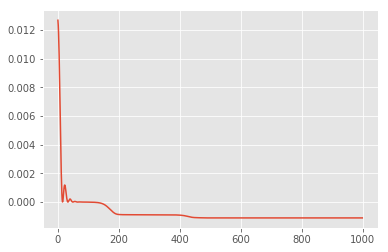

In [106]:
plt.plot(lh)
plt.show()
plt.close()

In [103]:
np.random.seed(0)
torch.manual_seed(0)
lh, coupling, init_coupling = OptimizeCoupling(osci_num, masks, cohn_loss, lr =.05, iterations=1,
                 kura_steps=100, burn_in_prop=0.0, alpha=.1, normalized=False)

> <ipython-input-94-3d39663f015e>(51)OptimizeCoupling()
     50     ipdb.set_trace()
---> 51     test_phase = kuramoto(init_phase, omega, normed_coupling, steps=2*kura_steps, alpha=alpha)
     52     phase_evol(test_phase.detach().numpy(), masks.data.numpy())

ipdb> masks.shape
torch.Size([1, 6, 720])
ipdb> exit


BdbQuit: 

In [96]:
np.random.seed(0)
torch.manual_seed(0)
lh, coupling, init_coupling = OptimizeSymmetricCoupling(osci_num, masks, cohn_loss, lr =.05, iterations=2000,
                 kura_steps=100, burn_in_prop=.5, alpha=.1, normalized=False)

TypeError: kuramoto() got multiple values for argument 'steps'

/home/matt/newtorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in power
  # This is added back by InteractiveShellApp.init_path()


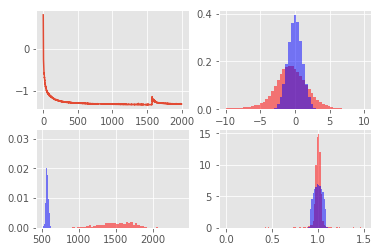

In [27]:
fig, axes = plt.subplots(2,2)

axes[0,0].plot(lh)

bins = np.linspace(-10,10,50)
axes[0,1].hist(coupling.reshape(-1),bins=bins,color='r',alpha=.5, density=True)
axes[0,1].hist(init_coupling.reshape(-1),bins=bins,color='b',alpha=.5, density=True)

bins = np.linspace(0,200,100)
triu_ind = np.triu_indices(osci_num,k=1)
W_opt = np.zeros((osci_num, osci_num))
W_control = np.zeros((osci_num, osci_num))
W_opt[triu_ind[0],triu_ind[1]] = np.squeeze(coupling)
W_control[triu_ind[0],triu_ind[1]] = np.squeeze(init_coupling)
W_opt += W_opt.T
D_bar_opt = np.abs(W_opt).sum(1)
W_control += W_control.T
D_bar_control = np.abs(W_control).sum(1)

axes[1,0].hist(D_bar_opt.reshape(-1),50,color='r',alpha=.5, density=True)
axes[1,0].hist(D_bar_control.reshape(-1),50,color='b',alpha=.5, density=True)

evals_opt     = laplacian_spectrum(osci_num, coupling, normalized=True)
evals_control = laplacian_spectrum(osci_num, init_coupling, normalized=True)
bins = np.linspace(0.0,1.5,100)
axes[1,1].hist(evals_opt,bins=bins,color='r',alpha=.5, density=True)
axes[1,1].hist(evals_control,bins=bins,color='b',alpha=.5, density=True)
plt.show()
plt.close()

In [495]:
# Optimize coupling function
np.random.seed(0)
torch.manual_seed(0)

# Training parameters

omega_name = 'uniform'
num_units = 4
num_groups = 4
num_training = 300
num_testing = 1
num_epochs = 1
kura_steps = 100
alpha=1e-2
num_hid=256
batch_size = 32
lr = 1e-3
LossFunc=cohn_loss_batch
transform= None
symmetric = True
eps=1e-12
burn_in_prop=0.5
splay_phases = torch.linspace(0, 2*np.pi, num_groups+1)[:-1]
phase_diffs = splay_phases.unsqueeze(1) - splay_phases.unsqueeze(0)
c_min = ((-1*torch.log(torch.abs(2*torch.sin(.5*(phase_diffs))) + eps))).sum((0,1)) / (num_groups)**2

mask = torch.stack([torch.eye(num_units) for _ in range(batch_size)])

# Training Loop
lh = []
cn = connectivity_net(num_units, num_hid=num_hid, transform=transform, symmetric=symmetric)
opt = torch.optim.Adam(cn.parameters(),lr=lr)
omega_dist, g0 = get_dist(omega_name)
for i in range(num_training):
    omega = omega_dist.sample(sample_shape=torch.Size([batch_size,num_units]))
    coupling = cn(omega)
    init_phase = torch.normal(np.pi,.01,size=(batch_size,num_units))
    opt.zero_grad()
    phase = kuramoto(init_phase, omega, coupling, steps=kura_steps,alpha=alpha)
    loss = LossFunc(phase, mask, burn_in_prop=burn_in_prop,eps=eps)
    elh.append(loss)
    loss.backward()
    opt.step()
    lh.append(loss.mean().detach().numpy())

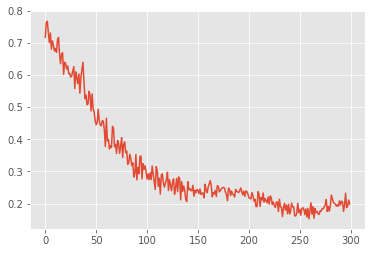

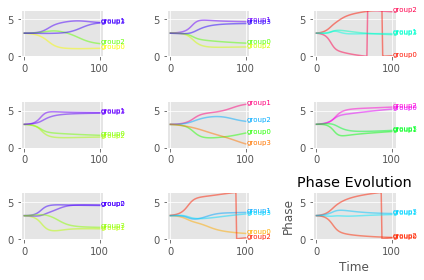

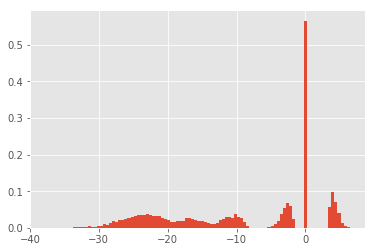

In [494]:
# Display

plt.plot(lh)
plt.show()
plt.close()
fig, axes = plt.subplots(3,3)
for a, ax in enumerate(axes.reshape(-1)):
    phase_evol(phase[:,a,...].unsqueeze(1).detach().numpy(), mask[a,...].unsqueeze(0).data.numpy(), ax=ax, action=None)
plt.show()
plt.close()

cpl = []
for _ in range(50):
    omega = omega_dist.sample(sample_shape=torch.Size([batch_size,num_units]))
    coupling = cn(omega)
    cpl.append(coupling.detach().numpy())
cpl = np.array(cpl).reshape(-1)
plt.hist(cpl,100, density=True)
plt.show()
plt.close()
